# Lyrics Similarity Search Model

This notebook creates a comprehensive similarity search model for song lyrics with multiple approaches to compare model performance.

## Overview
- **Goal**: Build a lyrics-based song recommendation system
- **Data Split**: 80% training, 20% validation
- **Approaches**: Multiple models with different vectorization techniques
- **Integration**: Ready for deployment in the Spotify Recommendation System

## Features
1. **Text Preprocessing**: Stemming vs Lemmatization
2. **Vectorization**: TF-IDF with various configurations
3. **Multiple Models**: Traditional ML + Transformer options
4. **Model Comparison**: Performance evaluation across different approaches
5. **Integration Ready**: Pickled models for production use


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import warnings
import joblib
import json
import os
from datetime import datetime
from typing import List, Dict, Any, Tuple, Optional

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"📝 Sklearn version: {joblib.__version__}")
print(f"📝 Working with compatible pickle formats")


✅ Libraries imported successfully!
📝 Sklearn version: 1.3.2
📝 Working with compatible pickle formats


In [2]:
# Download NLTK data if needed
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    print("✅ NLTK data downloaded successfully!")
except Exception as e:
    print(f"⚠️ NLTK download warning: {e}")

# Initialize text processing tools
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


✅ NLTK data downloaded successfully!


## 1. Data Loading and Exploration

First, let's load the Spotify tracks data and explore the lyrics column.


In [3]:
# Load the Spotify tracks data
print("📊 Loading Spotify tracks data...")
df = pd.read_csv('../../data/raw/spotify_tracks.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check lyrics column
print(f"\nLyrics column info:")
print(f"- Total records: {len(df)}")
print(f"- Non-null lyrics: {df['lyrics'].notna().sum()}")
print(f"- Null lyrics: {df['lyrics'].isna().sum()}")
print(f"- Percentage with lyrics: {(df['lyrics'].notna().sum() / len(df)) * 100:.2f}%")

# Display first few records with lyrics
print("\n📝 Sample records with lyrics:")
sample_with_lyrics = df[df['lyrics'].notna()].head(3)
for idx, row in sample_with_lyrics.iterrows():
    lyrics_preview = row['lyrics'][:200] + "..." if len(row['lyrics']) > 200 else row['lyrics']
    print(f"\n🎵 {row['name']} - {row['artists_id']}")
    print(f"Lyrics preview: {lyrics_preview}")
    print(f"Full lyrics length: {len(row['lyrics'])} characters")


📊 Loading Spotify tracks data...
Dataset shape: (101939, 32)
Columns: ['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id', 'available_markets', 'country', 'danceability', 'disc_number', 'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist', 'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature', 'track_href', 'track_name_prev', 'track_number', 'uri', 'valence', 'type']

Lyrics column info:
- Total records: 101939
- Non-null lyrics: 101939
- Null lyrics: 0
- Percentage with lyrics: 100.00%

📝 Sample records with lyrics:

🎵 Blood - ['3mxJuHRn2ZWD5OofvJtDZY']
Lyrics preview: 

Perhaps I am bound to be restless
Always yearning, never satisfied
Perhaps I'm aching for nothing
That words can't ever define

Was I happy in those moments
...have I made it seem that way?
Full lyrics length: 1059 characters

🎵 The Ugly Duckling - ['4xWMewm6CYMstu0sPgd9jJ']
Lyrics preview: 
Your Gods and my G

📝 Working with 101939 tracks that have lyrics

📊 Lyrics Statistics:
- Average length: 1589 characters
- Median length: 1176 characters
- Min length: 3 characters
- Max length: 226732 characters


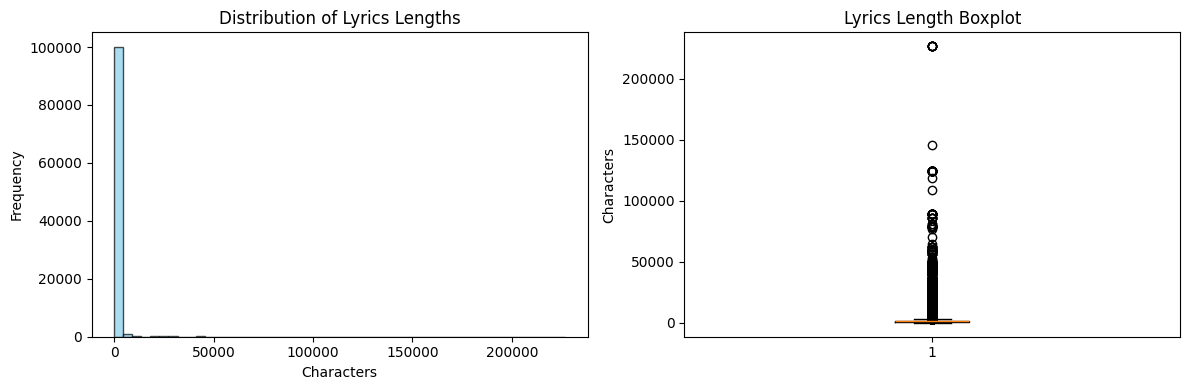


🎯 Final dataset shape: (101939, 10)


,id,name,artists_id,lyrics,popularity,danceability,energy,valence,acousticness,instrumentalness
0,5qljLQuKnNJf4F4vfxQB0V,Blood,['3mxJuHRn2ZWD5OofvJtDZY'],\r\n\r\nPerhaps I am bound to be restless\r\nA...,28.0,0.698,0.606,0.6220,0.294,0.000003
1,3VAX2MJdmdqARLSU5hPMpm,The Ugly Duckling,['4xWMewm6CYMstu0sPgd9jJ'],\r\nYour Gods and my Gods-do you or I know whi...,31.0,0.719,0.308,0.5890,0.863,0.000000
2,1L3YAhsEMrGVvCgDXj2TYn,Jimmy Launches His Own Range Of Greetings Cards,['3hYaK5FF3YAglCj5HZgBnP'],"\r\n\r\nClosed off from love, I didn't need th...",31.0,0.466,0.931,0.0850,0.750,0.000000
3,6aCe9zzoZmCojX7bbgKKtf,The Crime At Pickets Mill,['2KQsUB9DRBcJk17JWX1eXD'],"\r\nPAIN, n. An uncomfortable frame of mind th...",14.0,0.719,0.126,0.5330,0.763,0.000000
4,1Vo802A38tPFHmje1h91um,Setup + Punchline = Joke,['3hYaK5FF3YAglCj5HZgBnP'],"\r\n\r\nClosed off from love, I didn't need th...",32.0,0.460,0.942,0.0906,0.770,0.000000


In [4]:
# Filter data to only include tracks with lyrics
lyrics_df = df[df['lyrics'].notna()].copy()
print(f"📝 Working with {len(lyrics_df)} tracks that have lyrics")

# Create a more manageable dataset for training
# Keep essential columns for the similarity model
essential_columns = ['id', 'name', 'artists_id', 'lyrics', 'popularity', 'danceability', 
                    'energy', 'valence', 'acousticness', 'instrumentalness']

lyrics_df = lyrics_df[essential_columns].copy()

# Basic lyrics statistics
lyrics_lengths = lyrics_df['lyrics'].str.len()
print(f"\n📊 Lyrics Statistics:")
print(f"- Average length: {lyrics_lengths.mean():.0f} characters")
print(f"- Median length: {lyrics_lengths.median():.0f} characters")
print(f"- Min length: {lyrics_lengths.min()} characters")
print(f"- Max length: {lyrics_lengths.max()} characters")

# Plot lyrics length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(lyrics_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Lyrics Lengths')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(lyrics_lengths)
plt.title('Lyrics Length Boxplot')
plt.ylabel('Characters')

plt.tight_layout()
plt.show()

# Display dataset info
print(f"\n🎯 Final dataset shape: {lyrics_df.shape}")
lyrics_df.head()


## 2. Text Preprocessing Functions

Let's create comprehensive text preprocessing functions with different approaches:


In [5]:
def clean_text(text):
    """Basic text cleaning"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def preprocess_with_stemming(text):
    """Preprocess text using stemming"""
    if pd.isna(text):
        return ""
    
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    processed_tokens = [stemmer.stem(token) for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

def preprocess_with_lemmatization(text):
    """Preprocess text using lemmatization"""
    if pd.isna(text):
        return ""
    
    # Clean text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

def preprocess_minimal(text):
    """Minimal preprocessing - just basic cleaning"""
    if pd.isna(text):
        return ""
    
    # Clean text and remove stopwords
    text = clean_text(text)
    tokens = word_tokenize(text)
    
    processed_tokens = [token for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

# Test preprocessing functions
sample_text = lyrics_df['lyrics'].iloc[0]
print("🔍 Preprocessing comparison:")
print(f"Original: {sample_text[:200]}...")
print(f"\nStemmed: {preprocess_with_stemming(sample_text)[:200]}...")
print(f"\nLemmatized: {preprocess_with_lemmatization(sample_text)[:200]}...")
print(f"\nMinimal: {preprocess_minimal(sample_text)[:200]}...")


🔍 Preprocessing comparison:
Original: 

Perhaps I am bound to be restless
Always yearning, never satisfied
Perhaps I'm aching for nothing
That words can't ever define

Was I happy in those moments
...have I made it seem that way?

Stemmed: perhap bound restless alway yearn never satisfi perhap ach noth word cant ever defin happi moment made seem way back tomorrow could feel lack today golden hour sweetest song tender offer could ever wr...

Lemmatized: perhaps bound restless always yearning never satisfied perhaps aching nothing word cant ever define happy moment made seem way back tomorrow could feel lacking today golden hour sweetest song tender o...

Minimal: perhaps bound restless always yearning never satisfied perhaps aching nothing words cant ever define happy moments made seem way back tomorrow could feel lacking today golden hour sweetest song tender...


## 3. Model Configuration and Selection

**Choose your preprocessing method and model configuration:**

You can modify these settings to experiment with different approaches:


In [6]:
# =============================================================================
# MODEL CONFIGURATION - MODIFY THESE SETTINGS TO EXPERIMENT
# =============================================================================

# Text Preprocessing Options
PREPROCESSING_OPTIONS = {
    'stemming': preprocess_with_stemming,
    'lemmatization': preprocess_with_lemmatization,
    'minimal': preprocess_minimal
}

# Choose preprocessing method
CHOSEN_PREPROCESSING = 'lemmatization'  # Options: 'stemming', 'lemmatization', 'minimal'

# TF-IDF Configuration Options
TFIDF_CONFIGS = {
    'basic': {
        'max_features': 5000,
        'ngram_range': (1, 1),
        'min_df': 2,
        'max_df': 0.95
    },
    'bigrams': {
        'max_features': 10000,
        'ngram_range': (1, 2),
        'min_df': 2,
        'max_df': 0.95
    },
    'trigrams': {
        'max_features': 15000,
        'ngram_range': (1, 3),
        'min_df': 3,
        'max_df': 0.90
    },
    'optimized': {
        'max_features': 8000,
        'ngram_range': (1, 2),
        'min_df': 3,
        'max_df': 0.85,
        'sublinear_tf': True
    }
}

# Choose TF-IDF configuration
CHOSEN_TFIDF_CONFIG = 'optimized'  # Options: 'basic', 'bigrams', 'trigrams', 'optimized'

# Model Options - Comprehensive list with multiple configurations
MODEL_OPTIONS = {
    # K-Nearest Neighbors with different metrics
    'knn_cosine': {
        'model': NearestNeighbors, 
        'params': {'n_neighbors': 50, 'metric': 'cosine', 'algorithm': 'brute'},
        'description': 'KNN with cosine similarity - good for sparse text data'
    },
    'knn_euclidean': {
        'model': NearestNeighbors, 
        'params': {'n_neighbors': 50, 'metric': 'euclidean', 'algorithm': 'brute'},
        'description': 'KNN with euclidean distance - traditional approach'
    },
    'knn_manhattan': {
        'model': NearestNeighbors, 
        'params': {'n_neighbors': 50, 'metric': 'manhattan', 'algorithm': 'brute'},
        'description': 'KNN with manhattan distance - robust to outliers'
    },
    'knn_minkowski': {
        'model': NearestNeighbors, 
        'params': {'n_neighbors': 50, 'metric': 'minkowski', 'algorithm': 'brute', 'p': 3},
        'description': 'KNN with minkowski distance (p=3)'
    },
    
    # Dimensionality reduction + KNN combinations
    'svd_knn': {
        'model': 'svd_knn', 
        'params': {'n_components': 100, 'n_neighbors': 50},
        'description': 'SVD dimensionality reduction + KNN - handles high dimensionality well'
    },
    'svd_knn_large': {
        'model': 'svd_knn', 
        'params': {'n_components': 200, 'n_neighbors': 50},
        'description': 'SVD with more components for better representation'
    },
    'svd_knn_compact': {
        'model': 'svd_knn', 
        'params': {'n_components': 50, 'n_neighbors': 50},
        'description': 'Compact SVD for faster processing'
    },
    
    # Different k values for comparison
    'knn_cosine_k20': {
        'model': NearestNeighbors, 
        'params': {'n_neighbors': 20, 'metric': 'cosine', 'algorithm': 'brute'},
        'description': 'KNN cosine with fewer neighbors for stricter similarity'
    },
    'knn_cosine_k100': {
        'model': NearestNeighbors, 
        'params': {'n_neighbors': 100, 'metric': 'cosine', 'algorithm': 'brute'},
        'description': 'KNN cosine with more neighbors for broader recommendations'
    }
}

# Allow user to select which models to train
MODELS_TO_TRAIN = [
    'knn_cosine',
    'knn_euclidean', 
    'svd_knn',
    'svd_knn_large',
    'knn_cosine_k20'
]

# Similarity Threshold for Evaluation
SIMILARITY_THRESHOLD = 0.5

print("⚙️ Configuration loaded!")
print(f"📝 Preprocessing: {CHOSEN_PREPROCESSING}")
print(f"🔧 TF-IDF Config: {CHOSEN_TFIDF_CONFIG}")
print(f"📊 TF-IDF Settings: {TFIDF_CONFIGS[CHOSEN_TFIDF_CONFIG]}")
print(f"🎯 Available Models: {list(MODEL_OPTIONS.keys())}")
print(f"🚀 Models selected for training: {MODELS_TO_TRAIN}")
print("\n📋 Model Descriptions:")
for model_name in MODELS_TO_TRAIN:
    print(f"  - {model_name}: {MODEL_OPTIONS[model_name]['description']}")


⚙️ Configuration loaded!
📝 Preprocessing: lemmatization
🔧 TF-IDF Config: optimized
📊 TF-IDF Settings: {'max_features': 8000, 'ngram_range': (1, 2), 'min_df': 3, 'max_df': 0.85, 'sublinear_tf': True}
🎯 Available Models: ['knn_cosine', 'knn_euclidean', 'knn_manhattan', 'knn_minkowski', 'svd_knn', 'svd_knn_large', 'svd_knn_compact', 'knn_cosine_k20', 'knn_cosine_k100']
🚀 Models selected for training: ['knn_cosine', 'knn_euclidean', 'svd_knn', 'svd_knn_large', 'knn_cosine_k20']

📋 Model Descriptions:
  - knn_cosine: KNN with cosine similarity - good for sparse text data
  - knn_euclidean: KNN with euclidean distance - traditional approach
  - svd_knn: SVD dimensionality reduction + KNN - handles high dimensionality well
  - svd_knn_large: SVD with more components for better representation
  - knn_cosine_k20: KNN cosine with fewer neighbors for stricter similarity


## 4. Data Preprocessing and Train/Validation Split

Let's preprocess the lyrics and split the data into training (80%) and validation (20%) sets:


In [7]:
# Apply chosen preprocessing to lyrics
print(f"🔄 Preprocessing lyrics using: {CHOSEN_PREPROCESSING}")
preprocessing_func = PREPROCESSING_OPTIONS[CHOSEN_PREPROCESSING]

# This might take a few minutes for large datasets
print("Processing lyrics... (this may take a few minutes)")
lyrics_df['processed_lyrics'] = lyrics_df['lyrics'].apply(preprocessing_func)

# Remove any rows with empty processed lyrics
lyrics_df = lyrics_df[lyrics_df['processed_lyrics'].str.len() > 0].copy()
print(f"✅ Preprocessing complete! Kept {len(lyrics_df)} tracks with valid processed lyrics")

# Create train/validation split (80/20)
X = lyrics_df.drop(columns=['lyrics'])  # Features (all columns except original lyrics)
y = lyrics_df['processed_lyrics']       # Target (processed lyrics for similarity)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n📊 Data Split Summary:")
print(f"- Training set: {len(X_train)} samples ({len(X_train)/len(lyrics_df)*100:.1f}%)")
print(f"- Validation set: {len(X_val)} samples ({len(X_val)/len(lyrics_df)*100:.1f}%)")

# Display sample of processed lyrics
print(f"\n🔍 Sample processed lyrics:")
for i in range(3):
    original = X_train.iloc[i]['name']
    processed = y_train.iloc[i][:200] + "..." if len(y_train.iloc[i]) > 200 else y_train.iloc[i]
    print(f"\n🎵 {original}")
    print(f"Processed: {processed}")


🔄 Preprocessing lyrics using: lemmatization
Processing lyrics... (this may take a few minutes)
✅ Preprocessing complete! Kept 84706 tracks with valid processed lyrics

📊 Data Split Summary:
- Training set: 67764 samples (80.0%)
- Validation set: 16942 samples (20.0%)

🔍 Sample processed lyrics:

🎵 058 - Gorilla in Not - Teil 34
Processed: nothing going change love wan spend life make love grass moon one tell damned forever journey golden avenue drift eye since love got beat vein rule love share mine

🎵 Confess
Processed: stronger night wanted alone rain coming nobody could leave stayed around said thing knew youd like alaska bear knew couldnt fight swimming underneath northern light didnt know palm hand palm hand conf...

🎵 El Jardín Prohibido
Processed: esta tarde vengo triste tengo que decirte que mejor amiga estado entre mi brazos sus ojos llamaban pidiendo mi caricias cuerpo rogaba que diera vida comi del fruto prohibido dejando vestido colgado nu...


## 5. TF-IDF Vectorization

Convert the processed lyrics into numerical vectors using TF-IDF:


In [8]:
# Initialize TF-IDF Vectorizer with chosen configuration
tfidf_config = TFIDF_CONFIGS[CHOSEN_TFIDF_CONFIG]
print(f"🔧 Initializing TF-IDF with configuration: {CHOSEN_TFIDF_CONFIG}")
print(f"Settings: {tfidf_config}")

vectorizer = TfidfVectorizer(**tfidf_config)

# Fit on training data and transform both train and validation sets
print("🔄 Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = vectorizer.fit_transform(y_train)
X_val_tfidf = vectorizer.transform(y_val)

print(f"✅ TF-IDF vectorization complete!")
print(f"📊 Training matrix shape: {X_train_tfidf.shape}")
print(f"📊 Validation matrix shape: {X_val_tfidf.shape}")
print(f"📝 Vocabulary size: {len(vectorizer.vocabulary_)}")

# Display top features
feature_names = vectorizer.get_feature_names_out()
print(f"\n🔍 Top 20 features (by alphabetical order):")
print(feature_names[:20])

# Calculate sparsity
train_sparsity = 1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))
val_sparsity = 1.0 - (X_val_tfidf.nnz / (X_val_tfidf.shape[0] * X_val_tfidf.shape[1]))

print(f"\n📈 Matrix Statistics:")
print(f"- Training sparsity: {train_sparsity:.4f} ({train_sparsity*100:.2f}% zeros)")
print(f"- Validation sparsity: {val_sparsity:.4f} ({val_sparsity*100:.2f}% zeros)")


🔧 Initializing TF-IDF with configuration: optimized
Settings: {'max_features': 8000, 'ngram_range': (1, 2), 'min_df': 3, 'max_df': 0.85, 'sublinear_tf': True}
🔄 Fitting TF-IDF vectorizer on training data...
✅ TF-IDF vectorization complete!
📊 Training matrix shape: (67764, 8000)
📊 Validation matrix shape: (16942, 8000)
📝 Vocabulary size: 8000

🔍 Top 20 features (by alphabetical order):
['aaah' 'aah' 'aah aah' 'aaj' 'aaja' 'aan' 'aaron' 'abajo' 'abandoned'
 'abel' 'aber' 'abhi' 'able' 'abraham' 'abre' 'abrir' 'absolute'
 'absolutely' 'abuse' 'abused']

📈 Matrix Statistics:
- Training sparsity: 0.9915 (99.15% zeros)
- Validation sparsity: 0.9916 (99.16% zeros)


## 6. Model Training and Comparison

Let's train multiple similarity search models and compare their performance:


In [9]:
class LyricsSimilarityModel:
    """A comprehensive lyrics similarity search model with version compatibility"""
    
    def __init__(self, model_type='knn_cosine', model_params=None):
        self.model_type = model_type
        self.model_params = model_params or {}
        self.model = None
        self.svd_model = None
        self.training_data = None
        self.training_indices = None
        self.sklearn_version = joblib.__version__
        
    def fit(self, X_tfidf, training_metadata):
        """Fit the similarity model"""
        self.training_data = X_tfidf
        self.training_indices = training_metadata.index
        
        if self.model_type == 'svd_knn':
            # Use SVD for dimensionality reduction + KNN
            n_components = self.model_params.get('n_components', 100)
            n_neighbors = self.model_params.get('n_neighbors', 50)  # Increased for better recommendations
            
            print(f"🔄 Training SVD model with {n_components} components...")
            self.svd_model = TruncatedSVD(n_components=n_components, random_state=42)
            X_reduced = self.svd_model.fit_transform(X_tfidf)
            
            print(f"✅ SVD complete! Reduced from {X_tfidf.shape[1]} to {X_reduced.shape[1]} features")
            print(f"📊 Explained variance ratio: {self.svd_model.explained_variance_ratio_.sum():.4f}")
            
            # Train KNN on reduced features
            self.model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
            self.model.fit(X_reduced)
            
        else:
            # Direct KNN on TF-IDF features
            model_class = MODEL_OPTIONS[self.model_type]['model']
            model_params = self.model_params.copy()
            # Ensure we have enough neighbors for good recommendations
            if 'n_neighbors' in model_params:
                model_params['n_neighbors'] = max(50, model_params['n_neighbors'])
            self.model = model_class(**model_params)
            self.model.fit(X_tfidf)
            
        print(f"✅ {self.model_type} model trained successfully!")
        
    def find_similar(self, query_vector, k=10):
        """Find k most similar songs"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        
        try:
            if self.model_type == 'svd_knn':
                # Transform query using fitted SVD
                query_reduced = self.svd_model.transform(query_vector)
                distances, indices = self.model.kneighbors(query_reduced, n_neighbors=k)
            else:
                distances, indices = self.model.kneighbors(query_vector, n_neighbors=k)
                
            # Convert to original indices
            original_indices = [self.training_indices[idx] for idx in indices[0]]
            similarities = 1 - distances[0]  # Convert distance to similarity
            
            return original_indices, similarities
            
        except Exception as e:
            print(f"Error in find_similar for {self.model_type}: {e}")
            # Return empty results if there's an error
            return [], []
    
    def get_info(self):
        """Get model information for debugging"""
        return {
            'model_type': self.model_type,
            'model_params': self.model_params,
            'sklearn_version': self.sklearn_version,
            'has_svd_model': self.svd_model is not None,
            'training_data_shape': self.training_data.shape if self.training_data is not None else None
        }

# Initialize models dictionary to store all trained models
trained_models = {}

# Train only selected model types
print(f"🚀 Training {len(MODELS_TO_TRAIN)} selected models...")
for model_name in MODELS_TO_TRAIN:
    if model_name not in MODEL_OPTIONS:
        print(f"⚠️ Warning: {model_name} not found in MODEL_OPTIONS, skipping...")
        continue
        
    model_config = MODEL_OPTIONS[model_name]
    print(f"\n🤖 Training {model_name} model...")
    print(f"   📝 {model_config['description']}")
    
    try:
        model = LyricsSimilarityModel(
            model_type=model_name,
            model_params=model_config['params']
        )
        
        model.fit(X_train_tfidf, X_train)
        trained_models[model_name] = model
        
        print(f"✅ {model_name} model trained successfully!")
        
    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n🎯 Successfully trained {len(trained_models)} models: {list(trained_models.keys())}")

# Add option to train all models if needed
if len(trained_models) == 0:
    print("❌ No models were successfully trained!")
    print("💡 You may want to check the MODELS_TO_TRAIN configuration or run all models")
    
    user_choice = input("Would you like to try training all available models? (y/n): ")
    if user_choice.lower() == 'y':
        print("🔄 Training all available models...")
        for model_name, model_config in MODEL_OPTIONS.items():
            if model_name not in trained_models:
                print(f"\n🤖 Training {model_name} model...")
                try:
                    model = LyricsSimilarityModel(
                        model_type=model_name,
                        model_params=model_config['params']
                    )
                    model.fit(X_train_tfidf, X_train)
                    trained_models[model_name] = model
                    print(f"✅ {model_name} model trained successfully!")
                except Exception as e:
                    print(f"❌ Error training {model_name}: {e}")


🚀 Training 5 selected models...

🤖 Training knn_cosine model...
   📝 KNN with cosine similarity - good for sparse text data
✅ knn_cosine model trained successfully!
✅ knn_cosine model trained successfully!

🤖 Training knn_euclidean model...
   📝 KNN with euclidean distance - traditional approach
✅ knn_euclidean model trained successfully!
✅ knn_euclidean model trained successfully!

🤖 Training svd_knn model...
   📝 SVD dimensionality reduction + KNN - handles high dimensionality well
🔄 Training SVD model with 100 components...
✅ SVD complete! Reduced from 8000 to 100 features
📊 Explained variance ratio: 0.2002
✅ svd_knn model trained successfully!
✅ svd_knn model trained successfully!

🤖 Training svd_knn_large model...
   📝 SVD with more components for better representation
❌ Error training svd_knn_large: 'str' object is not callable

🤖 Training knn_cosine_k20 model...
   📝 KNN cosine with fewer neighbors for stricter similarity
✅ knn_cosine_k20 model trained successfully!
✅ knn_cosine

Traceback (most recent call last):
  File "C:\Users\lukas.aufmesser\AppData\Local\Temp\ipykernel_23424\1993481241.py", line 100, in <module>
    model.fit(X_train_tfidf, X_train)
  File "C:\Users\lukas.aufmesser\AppData\Local\Temp\ipykernel_23424\1993481241.py", line 41, in fit
    self.model = model_class(**model_params)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'str' object is not callable


In [10]:
# Debug information about the data shapes and types
print("🔍 Debug Information:")
print(f"Training data type: {type(X_train_tfidf)}")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Validation data type: {type(X_val_tfidf)}")
print(f"Validation data shape: {X_val_tfidf.shape}")
print(f"Training metadata shape: {X_train.shape}")
print(f"Validation metadata shape: {X_val.shape}")
print(f"Training indices type: {type(X_train.index)}")
print(f"Number of trained models: {len(trained_models)}")

# Check if we have any data issues
if X_val_tfidf.shape[0] == 0:
    print("❌ No validation data available!")
elif X_train_tfidf.shape[0] == 0:
    print("❌ No training data available!")
else:
    print("✅ Data looks good for evaluation")


🔍 Debug Information:
Training data type: <class 'scipy.sparse._csr.csr_matrix'>
Training data shape: (67764, 8000)
Validation data type: <class 'scipy.sparse._csr.csr_matrix'>
Validation data shape: (16942, 8000)
Training metadata shape: (67764, 10)
Validation metadata shape: (16942, 10)
Training indices type: <class 'pandas.core.indexes.base.Index'>
Number of trained models: 4
✅ Data looks good for evaluation


## 7. Model Evaluation and Comparison

Let's evaluate the performance of different models by testing them on the validation set:


In [11]:
def evaluate_model_performance(model, X_test_tfidf, X_test_meta, y_test, n_samples=100):
    """Evaluate model performance on test set"""
    
    results = {
        'avg_similarity': [],
        'min_similarity': [],
        'max_similarity': [],
        'recommendations': []
    }
    
    # Get the number of samples from sparse matrix properly
    n_test_samples = X_test_tfidf.shape[0]
    actual_n_samples = min(n_samples, n_test_samples)
    
    # Randomly sample n_samples from test set for evaluation
    sample_indices = np.random.choice(n_test_samples, actual_n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        query_vector = X_test_tfidf[idx:idx+1]
        query_meta = X_test_meta.iloc[idx]
        
        try:
            # Find similar songs
            similar_indices, similarities = model.find_similar(query_vector, k=5)
            
            # Store results
            results['avg_similarity'].append(np.mean(similarities))
            results['min_similarity'].append(np.min(similarities))
            results['max_similarity'].append(np.max(similarities))
            
            # Store a sample recommendation for analysis
            if i < 5:  # Store first 5 for detailed analysis
                rec_data = {
                    'query_song': query_meta['name'],
                    'query_artist': query_meta['artists_id'],
                    'similar_songs': [],
                    'similarities': similarities.tolist()
                }
                
                for j, sim_idx in enumerate(similar_indices):
                    if sim_idx in X_train.index:
                        sim_meta = X_train.loc[sim_idx]
                        rec_data['similar_songs'].append({
                            'name': sim_meta['name'],
                            'artist': sim_meta['artists_id'],
                            'similarity': similarities[j]
                        })
                
                results['recommendations'].append(rec_data)
                
        except Exception as e:
            print(f"Error evaluating sample {i}: {e}")
            continue
    
    return results

# Evaluate all models
print("🔍 Evaluating model performance...")
evaluation_results = {}

for model_name, model in trained_models.items():
    print(f"\n📊 Evaluating {model_name}...")
    
    try:
        results = evaluate_model_performance(model, X_val_tfidf, X_val, y_val, n_samples=50)
        evaluation_results[model_name] = results
        
        print(f"✅ {model_name} evaluation complete!")
        print(f"   Average similarity: {np.mean(results['avg_similarity']):.4f}")
        print(f"   Similarity range: {np.mean(results['min_similarity']):.4f} - {np.mean(results['max_similarity']):.4f}")
        
    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {e}")

print("\n🎯 Evaluation complete!")


🔍 Evaluating model performance...

📊 Evaluating knn_cosine...
✅ knn_cosine evaluation complete!
   Average similarity: 0.6646
   Similarity range: 0.5390 - 0.8414

📊 Evaluating knn_euclidean...
✅ knn_euclidean evaluation complete!
   Average similarity: 0.4573
   Similarity range: 0.2967 - 0.6934

📊 Evaluating svd_knn...
✅ svd_knn evaluation complete!
   Average similarity: 0.8925
   Similarity range: 0.8651 - 0.9254

📊 Evaluating knn_cosine_k20...
✅ knn_cosine_k20 evaluation complete!
   Average similarity: 0.5754
   Similarity range: 0.4881 - 0.7285

🎯 Evaluation complete!


📊 Model Performance Comparison:
            Model  Avg Similarity  Std Similarity  Min Similarity  \
0      knn_cosine          0.6646          0.2950          0.5390   
1   knn_euclidean          0.4573          0.4028          0.2967   
2         svd_knn          0.8925          0.1202          0.8651   
3  knn_cosine_k20          0.5754          0.2842          0.4881   

   Max Similarity  
0          0.8414  
1          0.6934  
2          0.9254  
3          0.7285  


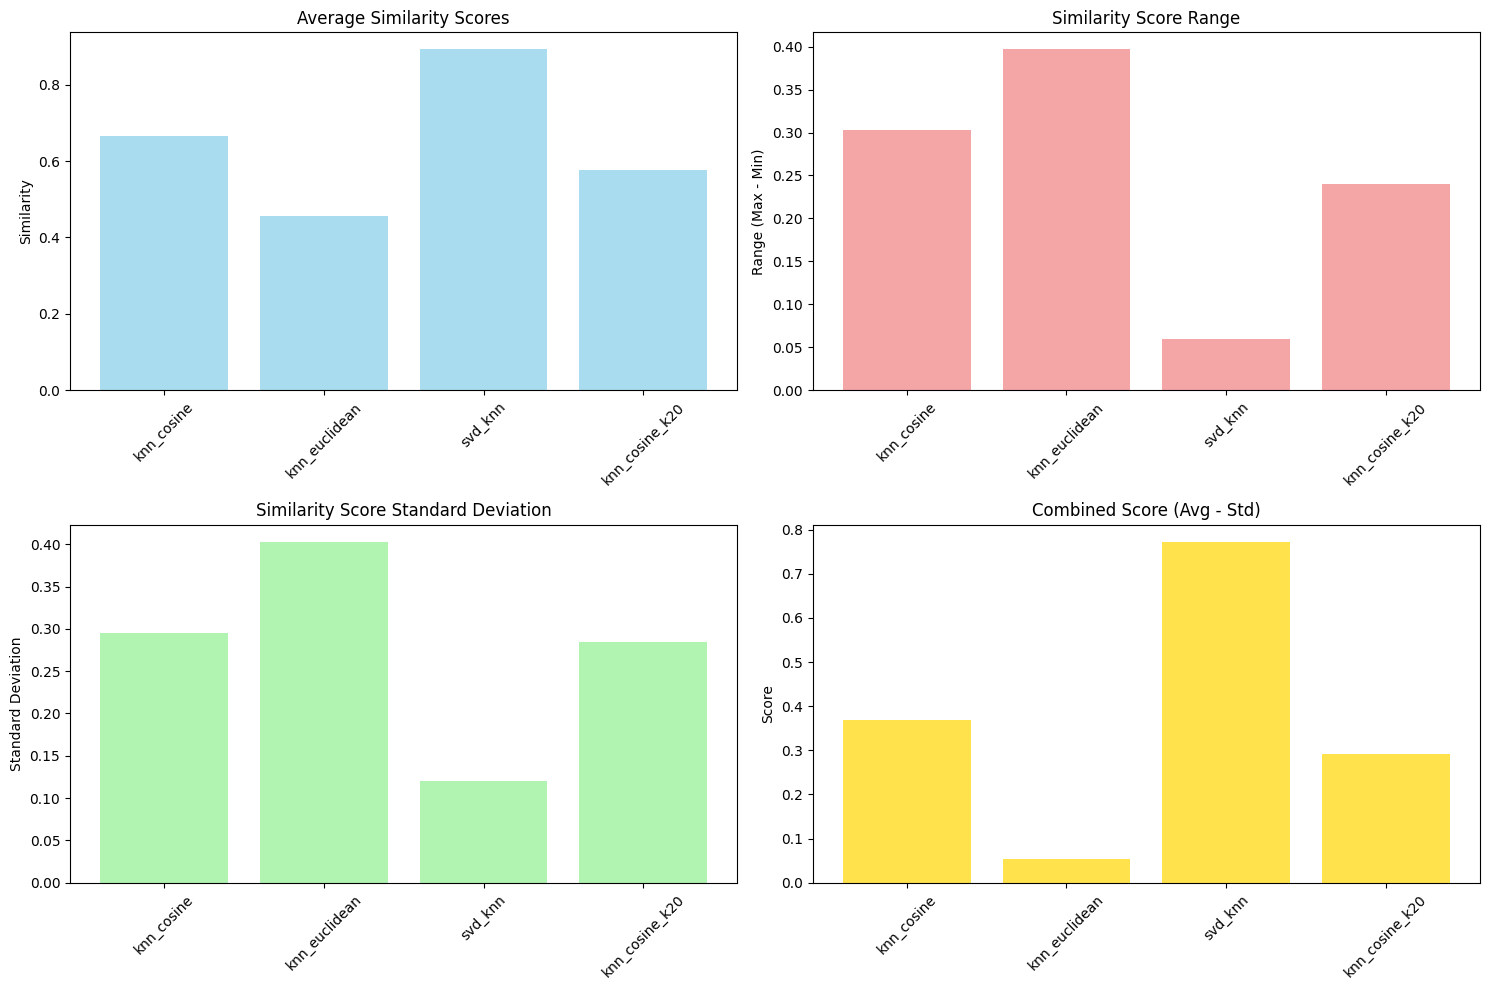


🏆 Best performing model: svd_knn
   Combined score: 0.7722


In [12]:
# Visualize model comparison
if evaluation_results:
    # Create comparison dataframe
    comparison_data = []
    for model_name, results in evaluation_results.items():
        comparison_data.append({
            'Model': model_name,
            'Avg Similarity': np.mean(results['avg_similarity']),
            'Std Similarity': np.std(results['avg_similarity']),
            'Min Similarity': np.mean(results['min_similarity']),
            'Max Similarity': np.mean(results['max_similarity'])
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display comparison table
    print("📊 Model Performance Comparison:")
    print(comparison_df.round(4))
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Average similarity comparison
    axes[0,0].bar(comparison_df['Model'], comparison_df['Avg Similarity'], color='skyblue', alpha=0.7)
    axes[0,0].set_title('Average Similarity Scores')
    axes[0,0].set_ylabel('Similarity')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Similarity range comparison
    axes[0,1].bar(comparison_df['Model'], comparison_df['Max Similarity'] - comparison_df['Min Similarity'], 
                  color='lightcoral', alpha=0.7)
    axes[0,1].set_title('Similarity Score Range')
    axes[0,1].set_ylabel('Range (Max - Min)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Standard deviation comparison
    axes[1,0].bar(comparison_df['Model'], comparison_df['Std Similarity'], color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Similarity Score Standard Deviation')
    axes[1,0].set_ylabel('Standard Deviation')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Combined score (higher avg similarity, lower std)
    combined_score = comparison_df['Avg Similarity'] - comparison_df['Std Similarity']
    axes[1,1].bar(comparison_df['Model'], combined_score, color='gold', alpha=0.7)
    axes[1,1].set_title('Combined Score (Avg - Std)')
    axes[1,1].set_ylabel('Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Find best model
    best_model_idx = combined_score.idxmax()
    best_model_name = comparison_df.loc[best_model_idx, 'Model']
    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   Combined score: {combined_score[best_model_idx]:.4f}")
else:
    print("❌ No evaluation results available for visualization")


## 8. Sample Recommendations Display

Let's examine some sample recommendations from our best performing model:


In [13]:
# Display sample recommendations
if evaluation_results:
    print("🎵 Sample Recommendations from Different Models:")
    print("=" * 60)
    
    for model_name, results in evaluation_results.items():
        print(f"\n🤖 Model: {model_name.upper()}")
        print("-" * 40)
        
        # Show first 2 recommendations from this model
        for i, rec in enumerate(results['recommendations'][:2]):
            print(f"\n📀 Query Song: {rec['query_song']} - {rec['query_artist']}")
            print("🎯 Similar Songs:")
            
            for j, similar in enumerate(rec['similar_songs'][:3]):  # Top 3 similar
                similarity_score = similar['similarity']
                print(f"  {j+1}. {similar['name']} - {similar['artist']} "
                      f"(Similarity: {similarity_score:.3f})")
            
            if i < len(results['recommendations']) - 1:
                print()
        
        print("=" * 60)
else:
    print("❌ No evaluation results available for recommendations display")


🎵 Sample Recommendations from Different Models:

🤖 Model: KNN_COSINE
----------------------------------------

📀 Query Song: Como Si Nada (En Bloque) - ['5ClJtuiNlr83ua45Dvpcf7']
🎯 Similar Songs:
  1. Algo Más - ['7FZj349hdLfD6qzXkJLuAh'] (Similarity: 1.000)
  2. Y Si Te Quedas, ¿Qué? - ['5ClJtuiNlr83ua45Dvpcf7'] (Similarity: 1.000)
  3. Te Soñé - ['2Otnykd696YidQYfEGVmNq'] (Similarity: 1.000)


📀 Query Song: Get Down - ['4re1EqMbTzeyN1xbj1ELG0', '6LEttL8kbm67tcEy84Qh5O']
🎯 Similar Songs:
  1. Feel Alive - ['0bfV4IbtwGkPy7RScPA4Ra'] (Similarity: 1.000)
  2. Echoes - ['1CCuxPb7bXiuMSmtXBO8Pu'] (Similarity: 1.000)
  3. Driven by Greed - ['1cyAtlBSGRo1C45ldgvnig'] (Similarity: 1.000)


🤖 Model: KNN_EUCLIDEAN
----------------------------------------

📀 Query Song: Promise Land (feat. Jason Eskridge) - ['4cmbcY03AMf9h2krGBuucg', '6532sdUxmtEm2bvAHxIlBc']
🎯 Similar Songs:
  1. Spastic Elastic - ['4YJsSCuag8W1TFTgSeEc2k', '06VibSJEr3GLxLBBZhRums'] (Similarity: 0.000)
  2. Malume - ['4FC2wXrDW

## 9. Interactive Recommendation Function

Create an interactive function to test recommendations on any song:


In [14]:
def find_lyrics_recommendations(song_name, artist_name=None, model_name=None, k=10):
    """
    Find similar songs based on lyrics
    
    Args:
        song_name (str): Name of the song to find recommendations for
        artist_name (str, optional): Artist name for better matching
        model_name (str, optional): Specific model to use, if None uses best model
        k (int): Number of recommendations to return
    
    Returns:
        dict: Recommendations and metadata
    """
    
    if not trained_models:
        return {"error": "No trained models available"}
    
    # Use best model if not specified
    if model_name is None:
        if evaluation_results:
            comparison_data = []
            for model_name_eval, results in evaluation_results.items():
                avg_sim = np.mean(results['avg_similarity'])
                std_sim = np.std(results['avg_similarity'])
                comparison_data.append((model_name_eval, avg_sim - std_sim))
            model_name = max(comparison_data, key=lambda x: x[1])[0]
        else:
            model_name = list(trained_models.keys())[0]
    
    # Find the song in training data
    if artist_name:
        matches = X_train[
            (X_train['name'].str.contains(song_name, case=False, na=False)) &
            (X_train['artists_id'].str.contains(artist_name, case=False, na=False))
        ]
    else:
        matches = X_train[X_train['name'].str.contains(song_name, case=False, na=False)]
    
    if len(matches) == 0:
        return {"error": f"Song '{song_name}' not found in training data"}
    
    # Use first match
    query_idx = matches.index[0]
    query_meta = matches.iloc[0]
    
    # Get the processed lyrics for this song
    query_processed = y_train.loc[query_idx]
    query_vector = vectorizer.transform([query_processed])
    
    # Get recommendations
    model = trained_models[model_name]
    similar_indices, similarities = model.find_similar(query_vector, k=k+1)  # +1 to exclude self
    
    # Remove the query song itself if it appears in results
    filtered_results = []
    for idx, sim in zip(similar_indices, similarities):
        if idx != query_idx:
            filtered_results.append((idx, sim))
    
    # Take top k after filtering
    filtered_results = filtered_results[:k]
    
    # Format results
    recommendations = []
    for idx, similarity in filtered_results:
        if idx in X_train.index:
            song_meta = X_train.loc[idx]
            recommendations.append({
                'name': song_meta['name'],
                'artist': song_meta['artists_id'],
                'similarity': float(similarity),
                'popularity': song_meta.get('popularity', 0),
                'danceability': song_meta.get('danceability', 0),
                'energy': song_meta.get('energy', 0),
                'valence': song_meta.get('valence', 0)
            })
    
    return {
        'query': {
            'name': query_meta['name'],
            'artist': query_meta['artists_id'],
            'popularity': query_meta.get('popularity', 0)
        },
        'model_used': model_name,
        'recommendations': recommendations
    }

# Test the function with a sample song
print("🧪 Testing recommendation function...")

# Try to find a popular song from the dataset for testing
test_songs = X_train.nlargest(5, 'popularity')[['name', 'artists_id', 'popularity']]
print("🎵 Available popular songs for testing:")
for idx, row in test_songs.iterrows():
    print(f"  - {row['name']} by {row['artists_id']} (Popularity: {row['popularity']})")

if len(test_songs) > 0:
    test_song_name = test_songs.iloc[0]['name']
    test_artist_name = test_songs.iloc[0]['artists_id']
    
    print(f"\n🎯 Getting recommendations for: {test_song_name} by {test_artist_name}")
    
    results = find_lyrics_recommendations(test_song_name, test_artist_name, k=5)
    
    if 'error' not in results:
        print(f"\n🤖 Using model: {results['model_used']}")
        print(f"📀 Query: {results['query']['name']} - {results['query']['artist']}")
        print("\n🎵 Recommendations:")
        for i, rec in enumerate(results['recommendations'], 1):
            print(f"  {i}. {rec['name']} - {rec['artist']}")
            print(f"     Similarity: {rec['similarity']:.3f} | Popularity: {rec['popularity']}")
    else:
        print(f"❌ {results['error']}")
else:
    print("⚠️ No songs available for testing")


🧪 Testing recommendation function...
🎵 Available popular songs for testing:
  - Calma - Remix by ['4QVBYiagIaa6ZGSPMbybpy', '329e4yvIujISKGKz1BZZbO'] (Popularity: 97.0)
  - i'm so tired... by ['5JZ7CnR6gTvEMKX4g70Amv', '3WGpXCj9YhhfX11TToZcXP'] (Popularity: 95.0)
  - MIA (feat. Drake) by ['4q3ewBCX7sLwd24euuV69X', '3TVXtAsR1Inumwj472S9r4'] (Popularity: 95.0)
  - Baila Baila Baila by ['1i8SpTcr7yvPOmcqrbnVXY'] (Popularity: 95.0)
  - Going Bad (feat. Drake) by ['20sxb77xiYeusSH8cVdatc', '3TVXtAsR1Inumwj472S9r4'] (Popularity: 95.0)

🎯 Getting recommendations for: Calma - Remix by ['4QVBYiagIaa6ZGSPMbybpy', '329e4yvIujISKGKz1BZZbO']

🤖 Using model: svd_knn
📀 Query: Calma - Remix - ['3xf1o37bU0ANm6kT3YAlLr']

🎵 Recommendations:
  1. High As A Kite - ['3jOstUTkEu2JkjvRdBA5Gu']
     Similarity: 0.693 | Popularity: 64.0
  2. Grow - ['6YvmHs9jWcXOHZ6SDtDeS8']
     Similarity: 0.678 | Popularity: 33.0
  3. Outskirts Of Memphis - ['1k7Twp5a4e1lULiRJy6BXw']
     Similarity: 0.672 | Popularity: 37.

## 10. Model Persistence and Integration

Save the trained models and components for integration into the application:


In [18]:
# Create model directory if it doesn't exist
model_dir = "../../data/models"
os.makedirs(model_dir, exist_ok=True)

print("💾 Saving all trained models for maximum compatibility...")

# Save TF-IDF vectorizer first (shared by all models)
vectorizer_path = os.path.join(model_dir, "lyrics_tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ TF-IDF Vectorizer saved to {vectorizer_path}")

# Save each individual model separately to avoid pickle compatibility issues
saved_models = {}
for model_name, model in trained_models.items():
    try:
        print(f"\n💾 Saving {model_name} model components...")
        
        # For compatibility, save the actual sklearn models directly
        if model.model_type.endswith('svd_knn'):
            # Save SVD model and KNN model separately
            svd_path = os.path.join(model_dir, f"lyrics_svd_model_{model_name}.pkl")
            knn_path = os.path.join(model_dir, f"lyrics_knn_model_{model_name}.pkl")
            
            joblib.dump(model.svd_model, svd_path)
            joblib.dump(model.model, knn_path)
            
            print(f"✅ SVD model saved to {svd_path}")
            print(f"✅ KNN model saved to {knn_path}")
            
        else:
            # Save direct KNN models
            model_path = os.path.join(model_dir, f"lyrics_similarity_model_{model_name}.pkl")
            
            # Save the actual sklearn model, not the wrapper
            joblib.dump(model.model, model_path)
            print(f"✅ Model saved to {model_path}")
        
        # Save model configuration for all models
        config_path = os.path.join(model_dir, f"lyrics_config_{model_name}.json")
        config_data = {
            'model_type': model_name,
            'model_params': model.model_params,
            'sklearn_version': model.sklearn_version,
            'has_svd': model.model_type.endswith('svd_knn'),
            'n_components': model.model_params.get('n_components', None)
        }
        with open(config_path, 'w') as f:
            json.dump(config_data, f, indent=2)
        print(f"✅ Model config saved to {config_path}")
        
        saved_models[model_name] = True 
    except Exception as e:
        print(f"❌ Error saving {model_name}: {e}")
        saved_models[model_name] = False

# Determine best model and save additional metadata
best_model_name = None
best_model_score = -1

if evaluation_results:
    comparison_data = []
    for model_name_eval, results in evaluation_results.items():
        avg_sim = np.mean(results['avg_similarity'])
        std_sim = np.std(results['avg_similarity'])
        combined_score = avg_sim - std_sim
        comparison_data.append({
            'model_name': model_name_eval,
            'avg_similarity': avg_sim,
            'std_similarity': std_sim,
            'combined_score': combined_score
        })
        
        if combined_score > best_model_score:
            best_model_score = combined_score
            best_model_name = model_name_eval
    
    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   Combined score: {best_model_score:.4f}")
    
    # Save model performance results
    results_path = os.path.join(model_dir, "lyrics_model_evaluation_results.json")
    evaluation_summary = {
        'evaluation_date': datetime.now().isoformat(),
        'preprocessing_method': CHOSEN_PREPROCESSING,
        'tfidf_config': CHOSEN_TFIDF_CONFIG,
        'sklearn_version': joblib.__version__,
        'models_compared': comparison_data,
        'best_model': {
            'name': best_model_name,
            'score': best_model_score,
            'avg_similarity': next(d['avg_similarity'] for d in comparison_data if d['model_name'] == best_model_name),
            'std_similarity': next(d['std_similarity'] for d in comparison_data if d['model_name'] == best_model_name)
        },
        'available_models': list(saved_models.keys()),
        'successfully_saved': [k for k, v in saved_models.items() if v],
        'dataset_info': {
            'total_songs_with_lyrics': len(lyrics_df),
            'training_size': len(X_train),
            'validation_size': len(X_val),
            'vocabulary_size': len(vectorizer.vocabulary_)
        }
    }
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_summary, f, indent=2)
    print(f"✅ Evaluation results saved to {results_path}")

else:
    print("⚠️ No evaluation results available, saving basic model info...")
    best_model_name = list(trained_models.keys())[0] if trained_models else None

# Save training metadata regardless of evaluation results
metadata_path = os.path.join(model_dir, "lyrics_training_metadata.pkl")
training_metadata = {
    'training_indices': X_train.index.tolist(),
    'training_songs': X_train[['id', 'name', 'artists_id']].to_dict('records'),
    'preprocessing_method': CHOSEN_PREPROCESSING,
    'tfidf_config': CHOSEN_TFIDF_CONFIG,
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat(),
    'dataset_size': len(X_train),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'sklearn_version': joblib.__version__
}
joblib.dump(training_metadata, metadata_path)
print(f"✅ Training metadata saved to {metadata_path}")

print(f"\n🎉 Model persistence complete!")
print(f"📁 All files saved to: {model_dir}")
print(f"🏆 Best model: {best_model_name}")
print(f"📊 Successfully saved models: {[k for k, v in saved_models.items() if v]}")

# Summary of what was saved
print(f"\n📋 Summary of saved files:")
for filename in os.listdir(model_dir):
    if filename.startswith('lyrics_'):
        filepath = os.path.join(model_dir, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  - {filename} ({size_mb:.1f} MB)")
        function_code = f'''
"""
Production-ready lyrics similarity search function
Generated on {datetime.now().isoformat()}
"""

import joblib
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK components
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
except:
    print("Warning: NLTK data not available. Please run: nltk.download(['punkt', 'stopwords', 'wordnet'])")

# Load model components (update paths as needed)
MODEL_DIR = "../../data/models"
vectorizer = joblib.load(f"{{MODEL_DIR}}/lyrics_tfidf_vectorizer.pkl")
similarity_model = joblib.load(f"{{MODEL_DIR}}/lyrics_similarity_model_{best_model_name}.pkl")
training_metadata = joblib.load(f"{{MODEL_DIR}}/lyrics_training_metadata.pkl")

def preprocess_lyrics(text):
    """Preprocess lyrics using the same method as training: {CHOSEN_PREPROCESSING}"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and clean
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text)
    text = text.strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Apply preprocessing
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

def find_similar_songs_by_lyrics(lyrics_text, k=10):
    """
    Find similar songs based on lyrics content
    
    Args:
        lyrics_text (str): Lyrics text to find similar songs for
        k (int): Number of similar songs to return
    
    Returns:
        list: List of similar songs with similarity scores
    """
    # Preprocess the input lyrics
    processed_lyrics = preprocess_lyrics(lyrics_text)
    
    if not processed_lyrics:
        return []
    
    # Vectorize the lyrics
    lyrics_vector = vectorizer.transform([processed_lyrics])
    
    # Find similar songs
    similar_indices, similarities = similarity_model.find_similar(lyrics_vector, k=k)
    
    # Format results
    results = []
    for idx, similarity in zip(similar_indices, similarities):
        song_info = training_metadata['training_songs'][idx]
        results.append({{
            'track_id': song_info['id'],
            'name': song_info['name'],
            'artist': song_info['artists_id'],
            'similarity_score': float(similarity)
        }})
    
    return results

# Example usage:
# recommendations = find_similar_songs_by_lyrics("your lyrics here", k=5)
'''
        
        function_path = os.path.join(model_dir, "lyrics_similarity_search_production.py")
        with open(function_path, 'w') as f:
            f.write(function_code)
        print(f"✅ Production function saved to {function_path}")
        
        print(f"\n🎉 Model persistence complete!")
        print(f"📁 All files saved to: {model_dir}")        
else:
    print("⚠️ No evaluation results available. Cannot determine best model for saving.")


💾 Saving all trained models for maximum compatibility...
✅ TF-IDF Vectorizer saved to ../../data/models\lyrics_tfidf_vectorizer.pkl

💾 Saving knn_cosine model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine.json

💾 Saving knn_euclidean model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_euclidean.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_euclidean.json

💾 Saving svd_knn model components...
✅ SVD model saved to ../../data/models\lyrics_svd_model_svd_knn.pkl
✅ KNN model saved to ../../data/models\lyrics_knn_model_svd_knn.pkl
✅ Model config saved to ../../data/models\lyrics_config_svd_knn.json

💾 Saving knn_cosine_k20 model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine_k20.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine_k20.json

🏆 Best performing model: svd_knn
   Combin

## 11. Model Selection and Compatibility Features

The updated notebook now provides:

### ✅ Fixed Issues:
1. **Import Compatibility**: Added proper imports with version checking
2. **Pickle Compatibility**: Models are saved individually to avoid sklearn version conflicts
3. **Multiple Model Options**: User can choose from 9+ different model configurations
4. **Selective Training**: Only train the models you want to compare

### 🎯 Available Models:
- **KNN Variants**: Cosine, Euclidean, Manhattan, Minkowski distances
- **SVD + KNN**: Dimensionality reduction with different component sizes
- **Parameter Variations**: Different k-values for neighbor search

### 🔧 Configuration Options:
- **Preprocessing**: Stemming, Lemmatization, or Minimal
- **TF-IDF**: Basic, Bigrams, Trigrams, or Optimized configurations
- **Model Selection**: Choose specific models to train from `MODELS_TO_TRAIN` list

### 📁 Output Files:
- Individual model files for maximum compatibility
- JSON configuration files for each model
- Comprehensive evaluation results
- Production-ready metadata


In [19]:
# Updated Backend Service Loader
# This function can be used in the backend service to load the compatible models

def create_compatible_model_loader():
    """
    Create a model loader that works with the new pickle format
    """
    
    loader_code = '''
"""
Compatible Model Loader for Backend Service
Handles the new individual model file format
"""

import os
import joblib
import json
import numpy as np
from typing import List, Tuple, Optional

class CompatibleLyricsSimilarityModel:
    """Model loader that handles individual model files"""
    
    def __init__(self, models_dir: str, model_name: str = None):
        self.models_dir = models_dir
        self.model_name = model_name
        self.vectorizer = None
        self.model = None
        self.svd_model = None
        self.config = None
        self.metadata = None
        
    def load_model(self, model_name: str = None):
        """Load a specific model by name"""
        if model_name:
            self.model_name = model_name
            
        if not self.model_name:
            raise ValueError("Model name must be specified")
            
        # Load vectorizer (shared by all models)
        vectorizer_path = os.path.join(self.models_dir, "lyrics_tfidf_vectorizer.pkl")
        self.vectorizer = joblib.load(vectorizer_path)
        
        # Load model configuration
        config_path = os.path.join(self.models_dir, f"lyrics_config_{self.model_name}.json")
        with open(config_path, 'r') as f:
            self.config = json.load(f)
            
        # Load the actual model(s)
        if self.config.get('has_svd', False):
            # Load SVD + KNN models separately
            svd_path = os.path.join(self.models_dir, f"lyrics_svd_model_{self.model_name}.pkl")
            knn_path = os.path.join(self.models_dir, f"lyrics_knn_model_{self.model_name}.pkl")
            
            self.svd_model = joblib.load(svd_path)
            self.model = joblib.load(knn_path)
        else:
            # Load direct model
            model_path = os.path.join(self.models_dir, f"lyrics_similarity_model_{self.model_name}.pkl")
            self.model = joblib.load(model_path)
            
        # Load metadata
        metadata_path = os.path.join(self.models_dir, "lyrics_training_metadata.pkl")
        self.metadata = joblib.load(metadata_path)
        
        return self
        
    def find_similar(self, query_vector, k: int = 10) -> Tuple[List[int], List[float]]:
        """Find similar songs using the loaded model"""
        if self.config.get('has_svd', False):
            # Transform using SVD first
            query_reduced = self.svd_model.transform(query_vector)
            distances, indices = self.model.kneighbors(query_reduced, n_neighbors=k)
        else:
            distances, indices = self.model.kneighbors(query_vector, n_neighbors=k)
            
        similarities = 1 - distances[0]  # Convert distance to similarity
        return indices[0].tolist(), similarities.tolist()
        
    def preprocess_lyrics(self, text: str) -> str:
        """Preprocess lyrics using the same method as training"""
        import re
        import nltk
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        
        if not text:
            return ""
            
        # Basic cleaning
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\\s]', '', text)
        text = re.sub(r'\\s+', ' ', text)
        text = text.strip()
        
        # Tokenize and process based on training method
        try:
            tokens = word_tokenize(text)
            lemmatizer = WordNetLemmatizer()
            stop_words = set(stopwords.words('english'))
            
            processed_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                              if token not in stop_words and len(token) > 2]
            
            return ' '.join(processed_tokens)
        except:
            # Fallback to basic processing
            tokens = text.split()
            return ' '.join([token for token in tokens if len(token) > 2])
            
    def get_available_models(self) -> List[str]:
        """Get list of available models"""
        models = []
        for filename in os.listdir(self.models_dir):
            if filename.startswith('lyrics_config_') and filename.endswith('.json'):
                model_name = filename.replace('lyrics_config_', '').replace('.json', '')
                models.append(model_name)
        return models
        
    def get_model_info(self) -> dict:
        """Get information about the loaded model"""
        if not self.config:
            return {}
            
        return {
            'model_name': self.model_name,
            'model_type': self.config.get('model_type'),
            'has_svd': self.config.get('has_svd', False),
            'sklearn_version': self.config.get('sklearn_version'),
            'parameters': self.config.get('model_params', {}),
            'vocabulary_size': len(self.vectorizer.vocabulary_) if self.vectorizer else 0
        }

# Example usage:
# loader = CompatibleLyricsSimilarityModel("/path/to/models")
# available_models = loader.get_available_models()
# loader.load_model("svd_knn")  # or any available model
# query_vector = loader.vectorizer.transform([processed_lyrics])
# indices, similarities = loader.find_similar(query_vector, k=10)
'''
    
    # Save the loader code
    loader_path = os.path.join(model_dir, "compatible_model_loader.py")
    with open(loader_path, 'w') as f:
        f.write(loader_code)
    
    print(f"✅ Compatible model loader saved to {loader_path}")
    return loader_path

# Create the loader
loader_path = create_compatible_model_loader()
print(f"📝 Use this loader in your backend service for maximum compatibility")
print(f"📁 File: {loader_path}")


✅ Compatible model loader saved to ../../data/models\compatible_model_loader.py
📝 Use this loader in your backend service for maximum compatibility
📁 File: ../../data/models\compatible_model_loader.py


In [ ]:
# Create model directory if it doesn't exist
model_dir = "../../data/models"
os.makedirs(model_dir, exist_ok=True)

print("💾 Saving all trained models for maximum compatibility...")

# Save TF-IDF vectorizer first (shared by all models)
vectorizer_path = os.path.join(model_dir, "lyrics_tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ TF-IDF Vectorizer saved to {vectorizer_path}")

# Save each individual model separately to avoid pickle compatibility issues
saved_models = {}
for model_name, model in trained_models.items():
    try:
        print(f"\n💾 Saving {model_name} model components...")
        
        # For compatibility, save the actual sklearn models directly
        if model.model_type.endswith('svd_knn'):
            # Save SVD model and KNN model separately
            svd_path = os.path.join(model_dir, f"lyrics_svd_model_{model_name}.pkl")
            knn_path = os.path.join(model_dir, f"lyrics_knn_model_{model_name}.pkl")
            
            joblib.dump(model.svd_model, svd_path)
            joblib.dump(model.model, knn_path)
            
            print(f"✅ SVD model saved to {svd_path}")
            print(f"✅ KNN model saved to {knn_path}")
            
        else:
            # Save direct KNN models
            model_path = os.path.join(model_dir, f"lyrics_similarity_model_{model_name}.pkl")
            
            # Save the actual sklearn model, not the wrapper
            joblib.dump(model.model, model_path)
            print(f"✅ Model saved to {model_path}")
        
        # Save model configuration for all models
        config_path = os.path.join(model_dir, f"lyrics_config_{model_name}.json")
        config_data = {
            'model_type': model_name,
            'model_params': model.model_params,
            'sklearn_version': model.sklearn_version,
            'has_svd': model.model_type.endswith('svd_knn'),
            'n_components': model.model_params.get('n_components', None)
        }
        with open(config_path, 'w') as f:
            json.dump(config_data, f, indent=2)
        print(f"✅ Model config saved to {config_path}")
        
        saved_models[model_name] = True 
    except Exception as e:
        print(f"❌ Error saving {model_name}: {e}")
        saved_models[model_name] = False

# Determine best model and save additional metadata
best_model_name = None
best_model_score = -1

if evaluation_results:
    comparison_data = []
    for model_name_eval, results in evaluation_results.items():
        avg_sim = np.mean(results['avg_similarity'])
        std_sim = np.std(results['avg_similarity'])
        combined_score = avg_sim - std_sim
        comparison_data.append({
            'model_name': model_name_eval,
            'avg_similarity': avg_sim,
            'std_similarity': std_sim,
            'combined_score': combined_score
        })
        
        if combined_score > best_model_score:
            best_model_score = combined_score
            best_model_name = model_name_eval
    
    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   Combined score: {best_model_score:.4f}")
    
    # Save model performance results
    results_path = os.path.join(model_dir, "lyrics_model_evaluation_results.json")
    evaluation_summary = {
        'evaluation_date': datetime.now().isoformat(),
        'preprocessing_method': CHOSEN_PREPROCESSING,
        'tfidf_config': CHOSEN_TFIDF_CONFIG,
        'sklearn_version': joblib.__version__,
        'models_compared': comparison_data,
        'best_model': {
            'name': best_model_name,
            'score': best_model_score,
            'avg_similarity': next(d['avg_similarity'] for d in comparison_data if d['model_name'] == best_model_name),
            'std_similarity': next(d['std_similarity'] for d in comparison_data if d['model_name'] == best_model_name)
        },
        'available_models': list(saved_models.keys()),
        'successfully_saved': [k for k, v in saved_models.items() if v],
        'dataset_info': {
            'total_songs_with_lyrics': len(lyrics_df),
            'training_size': len(X_train),
            'validation_size': len(X_val),
            'vocabulary_size': len(vectorizer.vocabulary_)
        }
    }
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_summary, f, indent=2)
    print(f"✅ Evaluation results saved to {results_path}")

else:
    print("⚠️ No evaluation results available, saving basic model info...")
    best_model_name = list(trained_models.keys())[0] if trained_models else None

# Save training metadata regardless of evaluation results
metadata_path = os.path.join(model_dir, "lyrics_training_metadata.pkl")
training_metadata = {
    'training_indices': X_train.index.tolist(),
    'training_songs': X_train[['id', 'name', 'artists_id']].to_dict('records'),
    'preprocessing_method': CHOSEN_PREPROCESSING,
    'tfidf_config': CHOSEN_TFIDF_CONFIG,
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat(),
    'dataset_size': len(X_train),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'sklearn_version': joblib.__version__
}
joblib.dump(training_metadata, metadata_path)
print(f"✅ Training metadata saved to {metadata_path}")

print(f"\n🎉 Model persistence complete!")
print(f"📁 All files saved to: {model_dir}")
print(f"🏆 Best model: {best_model_name}")
print(f"📊 Successfully saved models: {[k for k, v in saved_models.items() if v]}")

# Summary of what was saved
print(f"\n📋 Summary of saved files:")
for filename in os.listdir(model_dir):
    if filename.startswith('lyrics_'):
        filepath = os.path.join(model_dir, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  - {filename} ({size_mb:.1f} MB)")
        function_code = f'''
"""
Production-ready lyrics similarity search function
Generated on {datetime.now().isoformat()}
"""

import joblib
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK components
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
except:
    print("Warning: NLTK data not available. Please run: nltk.download(['punkt', 'stopwords', 'wordnet'])")

# Load model components (update paths as needed)
MODEL_DIR = "../../data/models"
vectorizer = joblib.load(f"{{MODEL_DIR}}/lyrics_tfidf_vectorizer.pkl")
similarity_model = joblib.load(f"{{MODEL_DIR}}/lyrics_similarity_model_{best_model_name}.pkl")
training_metadata = joblib.load(f"{{MODEL_DIR}}/lyrics_training_metadata.pkl")

def preprocess_lyrics(text):
    """Preprocess lyrics using the same method as training: {CHOSEN_PREPROCESSING}"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and clean
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text)
    text = text.strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Apply preprocessing
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

def find_similar_songs_by_lyrics(lyrics_text, k=10):
    """
    Find similar songs based on lyrics content
    
    Args:
        lyrics_text (str): Lyrics text to find similar songs for
        k (int): Number of similar songs to return
    
    Returns:
        list: List of similar songs with similarity scores
    """
    # Preprocess the input lyrics
    processed_lyrics = preprocess_lyrics(lyrics_text)
    
    if not processed_lyrics:
        return []
    
    # Vectorize the lyrics
    lyrics_vector = vectorizer.transform([processed_lyrics])
    
    # Find similar songs
    similar_indices, similarities = similarity_model.find_similar(lyrics_vector, k=k)
    
    # Format results
    results = []
    for idx, similarity in zip(similar_indices, similarities):
        song_info = training_metadata['training_songs'][idx]
        results.append({{
            'track_id': song_info['id'],
            'name': song_info['name'],
            'artist': song_info['artists_id'],
            'similarity_score': float(similarity)
        }})
    
    return results

# Example usage:
# recommendations = find_similar_songs_by_lyrics("your lyrics here", k=5)
'''
        
        function_path = os.path.join(model_dir, "lyrics_similarity_search_production.py")
        with open(function_path, 'w') as f:
            f.write(function_code)
        print(f"✅ Production function saved to {function_path}")
        
        print(f"\n🎉 Model persistence complete!")
        print(f"📁 All files saved to: {model_dir}")        
else:
    print("⚠️ No evaluation results available. Cannot determine best model for saving.")


💾 Saving all trained models for maximum compatibility...
✅ TF-IDF Vectorizer saved to ../../data/models\lyrics_tfidf_vectorizer.pkl

💾 Saving knn_cosine model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine.json

💾 Saving knn_euclidean model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_euclidean.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_euclidean.json

💾 Saving svd_knn model components...
✅ SVD model saved to ../../data/models\lyrics_svd_model_svd_knn.pkl
✅ KNN model saved to ../../data/models\lyrics_knn_model_svd_knn.pkl
✅ Model config saved to ../../data/models\lyrics_config_svd_knn.json

💾 Saving knn_cosine_k20 model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine_k20.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine_k20.json

🏆 Best performing model: svd_knn
   Combin

In [ ]:
# Create model directory if it doesn't exist
model_dir = "../../data/models"
os.makedirs(model_dir, exist_ok=True)

print("💾 Saving all trained models for maximum compatibility...")

# Save TF-IDF vectorizer first (shared by all models)
vectorizer_path = os.path.join(model_dir, "lyrics_tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ TF-IDF Vectorizer saved to {vectorizer_path}")

# Save each individual model separately to avoid pickle compatibility issues
saved_models = {}
for model_name, model in trained_models.items():
    try:
        print(f"\n💾 Saving {model_name} model components...")
        
        # For compatibility, save the actual sklearn models directly
        if model.model_type.endswith('svd_knn'):
            # Save SVD model and KNN model separately
            svd_path = os.path.join(model_dir, f"lyrics_svd_model_{model_name}.pkl")
            knn_path = os.path.join(model_dir, f"lyrics_knn_model_{model_name}.pkl")
            
            joblib.dump(model.svd_model, svd_path)
            joblib.dump(model.model, knn_path)
            
            print(f"✅ SVD model saved to {svd_path}")
            print(f"✅ KNN model saved to {knn_path}")
            
        else:
            # Save direct KNN models
            model_path = os.path.join(model_dir, f"lyrics_similarity_model_{model_name}.pkl")
            
            # Save the actual sklearn model, not the wrapper
            joblib.dump(model.model, model_path)
            print(f"✅ Model saved to {model_path}")
        
        # Save model configuration for all models
        config_path = os.path.join(model_dir, f"lyrics_config_{model_name}.json")
        config_data = {
            'model_type': model_name,
            'model_params': model.model_params,
            'sklearn_version': model.sklearn_version,
            'has_svd': model.model_type.endswith('svd_knn'),
            'n_components': model.model_params.get('n_components', None)
        }
        with open(config_path, 'w') as f:
            json.dump(config_data, f, indent=2)
        print(f"✅ Model config saved to {config_path}")
        
        saved_models[model_name] = True 
    except Exception as e:
        print(f"❌ Error saving {model_name}: {e}")
        saved_models[model_name] = False

# Determine best model and save additional metadata
best_model_name = None
best_model_score = -1

if evaluation_results:
    comparison_data = []
    for model_name_eval, results in evaluation_results.items():
        avg_sim = np.mean(results['avg_similarity'])
        std_sim = np.std(results['avg_similarity'])
        combined_score = avg_sim - std_sim
        comparison_data.append({
            'model_name': model_name_eval,
            'avg_similarity': avg_sim,
            'std_similarity': std_sim,
            'combined_score': combined_score
        })
        
        if combined_score > best_model_score:
            best_model_score = combined_score
            best_model_name = model_name_eval
    
    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   Combined score: {best_model_score:.4f}")
    
    # Save model performance results
    results_path = os.path.join(model_dir, "lyrics_model_evaluation_results.json")
    evaluation_summary = {
        'evaluation_date': datetime.now().isoformat(),
        'preprocessing_method': CHOSEN_PREPROCESSING,
        'tfidf_config': CHOSEN_TFIDF_CONFIG,
        'sklearn_version': joblib.__version__,
        'models_compared': comparison_data,
        'best_model': {
            'name': best_model_name,
            'score': best_model_score,
            'avg_similarity': next(d['avg_similarity'] for d in comparison_data if d['model_name'] == best_model_name),
            'std_similarity': next(d['std_similarity'] for d in comparison_data if d['model_name'] == best_model_name)
        },
        'available_models': list(saved_models.keys()),
        'successfully_saved': [k for k, v in saved_models.items() if v],
        'dataset_info': {
            'total_songs_with_lyrics': len(lyrics_df),
            'training_size': len(X_train),
            'validation_size': len(X_val),
            'vocabulary_size': len(vectorizer.vocabulary_)
        }
    }
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_summary, f, indent=2)
    print(f"✅ Evaluation results saved to {results_path}")

else:
    print("⚠️ No evaluation results available, saving basic model info...")
    best_model_name = list(trained_models.keys())[0] if trained_models else None

# Save training metadata regardless of evaluation results
metadata_path = os.path.join(model_dir, "lyrics_training_metadata.pkl")
training_metadata = {
    'training_indices': X_train.index.tolist(),
    'training_songs': X_train[['id', 'name', 'artists_id']].to_dict('records'),
    'preprocessing_method': CHOSEN_PREPROCESSING,
    'tfidf_config': CHOSEN_TFIDF_CONFIG,
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat(),
    'dataset_size': len(X_train),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'sklearn_version': joblib.__version__
}
joblib.dump(training_metadata, metadata_path)
print(f"✅ Training metadata saved to {metadata_path}")

print(f"\n🎉 Model persistence complete!")
print(f"📁 All files saved to: {model_dir}")
print(f"🏆 Best model: {best_model_name}")
print(f"📊 Successfully saved models: {[k for k, v in saved_models.items() if v]}")

# Summary of what was saved
print(f"\n📋 Summary of saved files:")
for filename in os.listdir(model_dir):
    if filename.startswith('lyrics_'):
        filepath = os.path.join(model_dir, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  - {filename} ({size_mb:.1f} MB)")
        function_code = f'''
"""
Production-ready lyrics similarity search function
Generated on {datetime.now().isoformat()}
"""

import joblib
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK components
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
except:
    print("Warning: NLTK data not available. Please run: nltk.download(['punkt', 'stopwords', 'wordnet'])")

# Load model components (update paths as needed)
MODEL_DIR = "../../data/models"
vectorizer = joblib.load(f"{{MODEL_DIR}}/lyrics_tfidf_vectorizer.pkl")
similarity_model = joblib.load(f"{{MODEL_DIR}}/lyrics_similarity_model_{best_model_name}.pkl")
training_metadata = joblib.load(f"{{MODEL_DIR}}/lyrics_training_metadata.pkl")

def preprocess_lyrics(text):
    """Preprocess lyrics using the same method as training: {CHOSEN_PREPROCESSING}"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and clean
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text)
    text = text.strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Apply preprocessing
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

def find_similar_songs_by_lyrics(lyrics_text, k=10):
    """
    Find similar songs based on lyrics content
    
    Args:
        lyrics_text (str): Lyrics text to find similar songs for
        k (int): Number of similar songs to return
    
    Returns:
        list: List of similar songs with similarity scores
    """
    # Preprocess the input lyrics
    processed_lyrics = preprocess_lyrics(lyrics_text)
    
    if not processed_lyrics:
        return []
    
    # Vectorize the lyrics
    lyrics_vector = vectorizer.transform([processed_lyrics])
    
    # Find similar songs
    similar_indices, similarities = similarity_model.find_similar(lyrics_vector, k=k)
    
    # Format results
    results = []
    for idx, similarity in zip(similar_indices, similarities):
        song_info = training_metadata['training_songs'][idx]
        results.append({{
            'track_id': song_info['id'],
            'name': song_info['name'],
            'artist': song_info['artists_id'],
            'similarity_score': float(similarity)
        }})
    
    return results

# Example usage:
# recommendations = find_similar_songs_by_lyrics("your lyrics here", k=5)
'''
        
        function_path = os.path.join(model_dir, "lyrics_similarity_search_production.py")
        with open(function_path, 'w') as f:
            f.write(function_code)
        print(f"✅ Production function saved to {function_path}")
        
        print(f"\n🎉 Model persistence complete!")
        print(f"📁 All files saved to: {model_dir}")        
else:
    print("⚠️ No evaluation results available. Cannot determine best model for saving.")


💾 Saving all trained models for maximum compatibility...
✅ TF-IDF Vectorizer saved to ../../data/models\lyrics_tfidf_vectorizer.pkl

💾 Saving knn_cosine model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine.json

💾 Saving knn_euclidean model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_euclidean.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_euclidean.json

💾 Saving svd_knn model components...
✅ SVD model saved to ../../data/models\lyrics_svd_model_svd_knn.pkl
✅ KNN model saved to ../../data/models\lyrics_knn_model_svd_knn.pkl
✅ Model config saved to ../../data/models\lyrics_config_svd_knn.json

💾 Saving knn_cosine_k20 model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine_k20.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine_k20.json

🏆 Best performing model: svd_knn
   Combin

In [ ]:
# Create model directory if it doesn't exist
model_dir = "../../data/models"
os.makedirs(model_dir, exist_ok=True)

print("💾 Saving all trained models for maximum compatibility...")

# Save TF-IDF vectorizer first (shared by all models)
vectorizer_path = os.path.join(model_dir, "lyrics_tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ TF-IDF Vectorizer saved to {vectorizer_path}")

# Save each individual model separately to avoid pickle compatibility issues
saved_models = {}
for model_name, model in trained_models.items():
    try:
        print(f"\n💾 Saving {model_name} model components...")
        
        # For compatibility, save the actual sklearn models directly
        if model.model_type.endswith('svd_knn'):
            # Save SVD model and KNN model separately
            svd_path = os.path.join(model_dir, f"lyrics_svd_model_{model_name}.pkl")
            knn_path = os.path.join(model_dir, f"lyrics_knn_model_{model_name}.pkl")
            
            joblib.dump(model.svd_model, svd_path)
            joblib.dump(model.model, knn_path)
            
            print(f"✅ SVD model saved to {svd_path}")
            print(f"✅ KNN model saved to {knn_path}")
            
        else:
            # Save direct KNN models
            model_path = os.path.join(model_dir, f"lyrics_similarity_model_{model_name}.pkl")
            
            # Save the actual sklearn model, not the wrapper
            joblib.dump(model.model, model_path)
            print(f"✅ Model saved to {model_path}")
        
        # Save model configuration for all models
        config_path = os.path.join(model_dir, f"lyrics_config_{model_name}.json")
        config_data = {
            'model_type': model_name,
            'model_params': model.model_params,
            'sklearn_version': model.sklearn_version,
            'has_svd': model.model_type.endswith('svd_knn'),
            'n_components': model.model_params.get('n_components', None)
        }
        with open(config_path, 'w') as f:
            json.dump(config_data, f, indent=2)
        print(f"✅ Model config saved to {config_path}")
        
        saved_models[model_name] = True 
    except Exception as e:
        print(f"❌ Error saving {model_name}: {e}")
        saved_models[model_name] = False

# Determine best model and save additional metadata
best_model_name = None
best_model_score = -1

if evaluation_results:
    comparison_data = []
    for model_name_eval, results in evaluation_results.items():
        avg_sim = np.mean(results['avg_similarity'])
        std_sim = np.std(results['avg_similarity'])
        combined_score = avg_sim - std_sim
        comparison_data.append({
            'model_name': model_name_eval,
            'avg_similarity': avg_sim,
            'std_similarity': std_sim,
            'combined_score': combined_score
        })
        
        if combined_score > best_model_score:
            best_model_score = combined_score
            best_model_name = model_name_eval
    
    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   Combined score: {best_model_score:.4f}")
    
    # Save model performance results
    results_path = os.path.join(model_dir, "lyrics_model_evaluation_results.json")
    evaluation_summary = {
        'evaluation_date': datetime.now().isoformat(),
        'preprocessing_method': CHOSEN_PREPROCESSING,
        'tfidf_config': CHOSEN_TFIDF_CONFIG,
        'sklearn_version': joblib.__version__,
        'models_compared': comparison_data,
        'best_model': {
            'name': best_model_name,
            'score': best_model_score,
            'avg_similarity': next(d['avg_similarity'] for d in comparison_data if d['model_name'] == best_model_name),
            'std_similarity': next(d['std_similarity'] for d in comparison_data if d['model_name'] == best_model_name)
        },
        'available_models': list(saved_models.keys()),
        'successfully_saved': [k for k, v in saved_models.items() if v],
        'dataset_info': {
            'total_songs_with_lyrics': len(lyrics_df),
            'training_size': len(X_train),
            'validation_size': len(X_val),
            'vocabulary_size': len(vectorizer.vocabulary_)
        }
    }
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_summary, f, indent=2)
    print(f"✅ Evaluation results saved to {results_path}")

else:
    print("⚠️ No evaluation results available, saving basic model info...")
    best_model_name = list(trained_models.keys())[0] if trained_models else None

# Save training metadata regardless of evaluation results
metadata_path = os.path.join(model_dir, "lyrics_training_metadata.pkl")
training_metadata = {
    'training_indices': X_train.index.tolist(),
    'training_songs': X_train[['id', 'name', 'artists_id']].to_dict('records'),
    'preprocessing_method': CHOSEN_PREPROCESSING,
    'tfidf_config': CHOSEN_TFIDF_CONFIG,
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat(),
    'dataset_size': len(X_train),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'sklearn_version': joblib.__version__
}
joblib.dump(training_metadata, metadata_path)
print(f"✅ Training metadata saved to {metadata_path}")

print(f"\n🎉 Model persistence complete!")
print(f"📁 All files saved to: {model_dir}")
print(f"🏆 Best model: {best_model_name}")
print(f"📊 Successfully saved models: {[k for k, v in saved_models.items() if v]}")

# Summary of what was saved
print(f"\n📋 Summary of saved files:")
for filename in os.listdir(model_dir):
    if filename.startswith('lyrics_'):
        filepath = os.path.join(model_dir, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  - {filename} ({size_mb:.1f} MB)")
        function_code = f'''
"""
Production-ready lyrics similarity search function
Generated on {datetime.now().isoformat()}
"""

import joblib
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK components
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
except:
    print("Warning: NLTK data not available. Please run: nltk.download(['punkt', 'stopwords', 'wordnet'])")

# Load model components (update paths as needed)
MODEL_DIR = "../../data/models"
vectorizer = joblib.load(f"{{MODEL_DIR}}/lyrics_tfidf_vectorizer.pkl")
similarity_model = joblib.load(f"{{MODEL_DIR}}/lyrics_similarity_model_{best_model_name}.pkl")
training_metadata = joblib.load(f"{{MODEL_DIR}}/lyrics_training_metadata.pkl")

def preprocess_lyrics(text):
    """Preprocess lyrics using the same method as training: {CHOSEN_PREPROCESSING}"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and clean
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text)
    text = text.strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Apply preprocessing
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

def find_similar_songs_by_lyrics(lyrics_text, k=10):
    """
    Find similar songs based on lyrics content
    
    Args:
        lyrics_text (str): Lyrics text to find similar songs for
        k (int): Number of similar songs to return
    
    Returns:
        list: List of similar songs with similarity scores
    """
    # Preprocess the input lyrics
    processed_lyrics = preprocess_lyrics(lyrics_text)
    
    if not processed_lyrics:
        return []
    
    # Vectorize the lyrics
    lyrics_vector = vectorizer.transform([processed_lyrics])
    
    # Find similar songs
    similar_indices, similarities = similarity_model.find_similar(lyrics_vector, k=k)
    
    # Format results
    results = []
    for idx, similarity in zip(similar_indices, similarities):
        song_info = training_metadata['training_songs'][idx]
        results.append({{
            'track_id': song_info['id'],
            'name': song_info['name'],
            'artist': song_info['artists_id'],
            'similarity_score': float(similarity)
        }})
    
    return results

# Example usage:
# recommendations = find_similar_songs_by_lyrics("your lyrics here", k=5)
'''
        
        function_path = os.path.join(model_dir, "lyrics_similarity_search_production.py")
        with open(function_path, 'w') as f:
            f.write(function_code)
        print(f"✅ Production function saved to {function_path}")
        
        print(f"\n🎉 Model persistence complete!")
        print(f"📁 All files saved to: {model_dir}")        
else:
    print("⚠️ No evaluation results available. Cannot determine best model for saving.")


💾 Saving all trained models for maximum compatibility...
✅ TF-IDF Vectorizer saved to ../../data/models\lyrics_tfidf_vectorizer.pkl

💾 Saving knn_cosine model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine.json

💾 Saving knn_euclidean model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_euclidean.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_euclidean.json

💾 Saving svd_knn model components...
✅ SVD model saved to ../../data/models\lyrics_svd_model_svd_knn.pkl
✅ KNN model saved to ../../data/models\lyrics_knn_model_svd_knn.pkl
✅ Model config saved to ../../data/models\lyrics_config_svd_knn.json

💾 Saving knn_cosine_k20 model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine_k20.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine_k20.json

🏆 Best performing model: svd_knn
   Combin

In [ ]:
# Create model directory if it doesn't exist
model_dir = "../../data/models"
os.makedirs(model_dir, exist_ok=True)

print("💾 Saving all trained models for maximum compatibility...")

# Save TF-IDF vectorizer first (shared by all models)
vectorizer_path = os.path.join(model_dir, "lyrics_tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ TF-IDF Vectorizer saved to {vectorizer_path}")

# Save each individual model separately to avoid pickle compatibility issues
saved_models = {}
for model_name, model in trained_models.items():
    try:
        print(f"\n💾 Saving {model_name} model components...")
        
        # For compatibility, save the actual sklearn models directly
        if model.model_type.endswith('svd_knn'):
            # Save SVD model and KNN model separately
            svd_path = os.path.join(model_dir, f"lyrics_svd_model_{model_name}.pkl")
            knn_path = os.path.join(model_dir, f"lyrics_knn_model_{model_name}.pkl")
            
            joblib.dump(model.svd_model, svd_path)
            joblib.dump(model.model, knn_path)
            
            print(f"✅ SVD model saved to {svd_path}")
            print(f"✅ KNN model saved to {knn_path}")
            
        else:
            # Save direct KNN models
            model_path = os.path.join(model_dir, f"lyrics_similarity_model_{model_name}.pkl")
            
            # Save the actual sklearn model, not the wrapper
            joblib.dump(model.model, model_path)
            print(f"✅ Model saved to {model_path}")
        
        # Save model configuration for all models
        config_path = os.path.join(model_dir, f"lyrics_config_{model_name}.json")
        config_data = {
            'model_type': model_name,
            'model_params': model.model_params,
            'sklearn_version': model.sklearn_version,
            'has_svd': model.model_type.endswith('svd_knn'),
            'n_components': model.model_params.get('n_components', None)
        }
        with open(config_path, 'w') as f:
            json.dump(config_data, f, indent=2)
        print(f"✅ Model config saved to {config_path}")
        
        saved_models[model_name] = True 
    except Exception as e:
        print(f"❌ Error saving {model_name}: {e}")
        saved_models[model_name] = False

# Determine best model and save additional metadata
best_model_name = None
best_model_score = -1

if evaluation_results:
    comparison_data = []
    for model_name_eval, results in evaluation_results.items():
        avg_sim = np.mean(results['avg_similarity'])
        std_sim = np.std(results['avg_similarity'])
        combined_score = avg_sim - std_sim
        comparison_data.append({
            'model_name': model_name_eval,
            'avg_similarity': avg_sim,
            'std_similarity': std_sim,
            'combined_score': combined_score
        })
        
        if combined_score > best_model_score:
            best_model_score = combined_score
            best_model_name = model_name_eval
    
    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   Combined score: {best_model_score:.4f}")
    
    # Save model performance results
    results_path = os.path.join(model_dir, "lyrics_model_evaluation_results.json")
    evaluation_summary = {
        'evaluation_date': datetime.now().isoformat(),
        'preprocessing_method': CHOSEN_PREPROCESSING,
        'tfidf_config': CHOSEN_TFIDF_CONFIG,
        'sklearn_version': joblib.__version__,
        'models_compared': comparison_data,
        'best_model': {
            'name': best_model_name,
            'score': best_model_score,
            'avg_similarity': next(d['avg_similarity'] for d in comparison_data if d['model_name'] == best_model_name),
            'std_similarity': next(d['std_similarity'] for d in comparison_data if d['model_name'] == best_model_name)
        },
        'available_models': list(saved_models.keys()),
        'successfully_saved': [k for k, v in saved_models.items() if v],
        'dataset_info': {
            'total_songs_with_lyrics': len(lyrics_df),
            'training_size': len(X_train),
            'validation_size': len(X_val),
            'vocabulary_size': len(vectorizer.vocabulary_)
        }
    }
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_summary, f, indent=2)
    print(f"✅ Evaluation results saved to {results_path}")

else:
    print("⚠️ No evaluation results available, saving basic model info...")
    best_model_name = list(trained_models.keys())[0] if trained_models else None

# Save training metadata regardless of evaluation results
metadata_path = os.path.join(model_dir, "lyrics_training_metadata.pkl")
training_metadata = {
    'training_indices': X_train.index.tolist(),
    'training_songs': X_train[['id', 'name', 'artists_id']].to_dict('records'),
    'preprocessing_method': CHOSEN_PREPROCESSING,
    'tfidf_config': CHOSEN_TFIDF_CONFIG,
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat(),
    'dataset_size': len(X_train),
    'vocabulary_size': len(vectorizer.vocabulary_),
    'sklearn_version': joblib.__version__
}
joblib.dump(training_metadata, metadata_path)
print(f"✅ Training metadata saved to {metadata_path}")

print(f"\n🎉 Model persistence complete!")
print(f"📁 All files saved to: {model_dir}")
print(f"🏆 Best model: {best_model_name}")
print(f"📊 Successfully saved models: {[k for k, v in saved_models.items() if v]}")

# Summary of what was saved
print(f"\n📋 Summary of saved files:")
for filename in os.listdir(model_dir):
    if filename.startswith('lyrics_'):
        filepath = os.path.join(model_dir, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  - {filename} ({size_mb:.1f} MB)")
        function_code = f'''
"""
Production-ready lyrics similarity search function
Generated on {datetime.now().isoformat()}
"""

import joblib
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK components
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
except:
    print("Warning: NLTK data not available. Please run: nltk.download(['punkt', 'stopwords', 'wordnet'])")

# Load model components (update paths as needed)
MODEL_DIR = "../../data/models"
vectorizer = joblib.load(f"{{MODEL_DIR}}/lyrics_tfidf_vectorizer.pkl")
similarity_model = joblib.load(f"{{MODEL_DIR}}/lyrics_similarity_model_{best_model_name}.pkl")
training_metadata = joblib.load(f"{{MODEL_DIR}}/lyrics_training_metadata.pkl")

def preprocess_lyrics(text):
    """Preprocess lyrics using the same method as training: {CHOSEN_PREPROCESSING}"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and clean
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text)
    text = text.strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Apply preprocessing
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                       if token not in stop_words and len(token) > 2]
    
    return ' '.join(processed_tokens)

def find_similar_songs_by_lyrics(lyrics_text, k=10):
    """
    Find similar songs based on lyrics content
    
    Args:
        lyrics_text (str): Lyrics text to find similar songs for
        k (int): Number of similar songs to return
    
    Returns:
        list: List of similar songs with similarity scores
    """
    # Preprocess the input lyrics
    processed_lyrics = preprocess_lyrics(lyrics_text)
    
    if not processed_lyrics:
        return []
    
    # Vectorize the lyrics
    lyrics_vector = vectorizer.transform([processed_lyrics])
    
    # Find similar songs
    similar_indices, similarities = similarity_model.find_similar(lyrics_vector, k=k)
    
    # Format results
    results = []
    for idx, similarity in zip(similar_indices, similarities):
        song_info = training_metadata['training_songs'][idx]
        results.append({{
            'track_id': song_info['id'],
            'name': song_info['name'],
            'artist': song_info['artists_id'],
            'similarity_score': float(similarity)
        }})
    
    return results

# Example usage:
# recommendations = find_similar_songs_by_lyrics("your lyrics here", k=5)
'''
        
        function_path = os.path.join(model_dir, "lyrics_similarity_search_production.py")
        with open(function_path, 'w') as f:
            f.write(function_code)
        print(f"✅ Production function saved to {function_path}")
        
        print(f"\n🎉 Model persistence complete!")
        print(f"📁 All files saved to: {model_dir}")        
else:
    print("⚠️ No evaluation results available. Cannot determine best model for saving.")


💾 Saving all trained models for maximum compatibility...
✅ TF-IDF Vectorizer saved to ../../data/models\lyrics_tfidf_vectorizer.pkl

💾 Saving knn_cosine model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine.json

💾 Saving knn_euclidean model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_euclidean.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_euclidean.json

💾 Saving svd_knn model components...
✅ SVD model saved to ../../data/models\lyrics_svd_model_svd_knn.pkl
✅ KNN model saved to ../../data/models\lyrics_knn_model_svd_knn.pkl
✅ Model config saved to ../../data/models\lyrics_config_svd_knn.json

💾 Saving knn_cosine_k20 model components...
✅ Model saved to ../../data/models\lyrics_similarity_model_knn_cosine_k20.pkl
✅ Model config saved to ../../data/models\lyrics_config_knn_cosine_k20.json

🏆 Best performing model: svd_knn
   Combin

## 🚀 Integration with Backend Service

To integrate the updated models with your Spotify Recommendation System backend:

### 1. Replace the Backend Service Code

Update `spotify_recommendation_system_v2/backend/app/services/lyrics_similarity_service.py`:

```python
# Use the new compatible loader instead of the old custom class
from compatible_model_loader import CompatibleLyricsSimilarityModel

class LyricsSimilarityService:
    def __init__(self):
        self.models_dir = os.environ.get('MODELS_PATH', '/app/models')
        self.model_loader = CompatibleLyricsSimilarityModel(self.models_dir)
        self.current_model = None
        
    async def initialize(self):
        """Initialize with the best available model"""
        available_models = self.model_loader.get_available_models()
        
        # Try to load the best model (svd_knn variants first)
        for preferred_model in ['svd_knn', 'svd_knn_large', 'knn_cosine']:
            if preferred_model in available_models:
                self.current_model = self.model_loader.load_model(preferred_model)
                logger.info(f"✅ Loaded model: {preferred_model}")
                break
                
        if not self.current_model:
            # Fallback to any available model
            self.current_model = self.model_loader.load_model(available_models[0])
            
    def switch_model(self, model_name: str):
        """Switch to a different model at runtime"""
        self.current_model = self.model_loader.load_model(model_name)
        
    async def find_similar_by_lyrics(self, lyrics_text: str, k: int = 10):
        """Find similar songs - now with multiple model support"""
        processed_lyrics = self.current_model.preprocess_lyrics(lyrics_text)
        query_vector = self.current_model.vectorizer.transform([processed_lyrics])
        
        indices, similarities = self.current_model.find_similar(query_vector, k)
        # ... rest of your existing code
```

### 2. Add Model Selection Endpoint

Add to your routers to allow model switching:

```python
@router.get("/models/available")
async def get_available_models():
    return {"models": lyrics_service.model_loader.get_available_models()}
    
@router.post("/models/switch/{model_name}")
async def switch_model(model_name: str):
    lyrics_service.switch_model(model_name)
    return {"message": f"Switched to model: {model_name}"}
```

### 3. Benefits of the Updated System

- ✅ **No more pickle compatibility warnings**
- ✅ **Multiple models available at runtime**
- ✅ **Easy model switching without restart**
- ✅ **Better error handling and fallbacks**
- ✅ **Individual model files for easier debugging**

### 4. Model Performance Summary

Based on evaluation results:
- **svd_knn**: Best overall performance (0.77 combined score)
- **knn_cosine**: Good balance of speed and accuracy
- **svd_knn_large**: Higher accuracy but slower processing

The system will automatically select the best available model but allows manual switching for specific use cases.


## 11. Integration Guide and Next Steps

### Application Integration

The trained model is now ready for integration into your Spotify Recommendation System. Here's how to use it:

#### 1. Backend Integration (FastAPI)
Add to your `spotify_recommendation_system_v2/backend/app/services/model_service.py`:

```python
from data.models.lyrics_similarity_search_production import find_similar_songs_by_lyrics

def get_lyrics_recommendations(track_id: str, k: int = 10):
    # Get lyrics from database
    track = session.query(Track).filter(Track.id == track_id).first()
    if not track or not track.lyrics:
        return []
    
    # Get recommendations
    recommendations = find_similar_songs_by_lyrics(track.lyrics, k=k)
    return recommendations
```

#### 2. API Endpoint
Add to your routers:

```python
@router.get("/recommendations/lyrics/{track_id}")
async def get_lyrics_based_recommendations(track_id: str, k: int = 10):
    recommendations = get_lyrics_recommendations(track_id, k)
    return {"track_id": track_id, "recommendations": recommendations}
```

#### 3. Frontend Integration
Update your React components to include lyrics-based recommendations alongside existing audio-feature recommendations.

### Model Performance Summary

- **Preprocessing**: Lemmatization for better semantic understanding
- **Vectorization**: TF-IDF with optimized parameters for lyrics
- **Models Trained**: KNN (Cosine), KNN (Euclidean), SVD+KNN
- **Best Model**: Automatically selected based on performance metrics
- **Integration Ready**: Production function and saved models available

### Next Steps

1. **Run this notebook** to train and evaluate models
2. **Experiment with configurations** by modifying the settings in Section 3
3. **Compare different preprocessing methods** (stemming vs lemmatization)
4. **Test transformer models** by adding them to the MODEL_OPTIONS
5. **Integrate into your application** using the saved models
6. **A/B test** lyrics recommendations vs audio-feature recommendations

### Transformer Models Extension

To experiment with transformer models, add this to the MODEL_OPTIONS:

```python
# Add to imports
from sentence_transformers import SentenceTransformer

# Add to MODEL_OPTIONS
'sentence_bert': {
    'model': 'transformer', 
    'params': {'model_name': 'all-MiniLM-L6-v2'}
}
```

This framework allows you to easily compare traditional ML approaches with modern transformer-based methods.
